# Import Libraries

In [41]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras import activations
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from keras.layers import Dropout
from tensorflow.keras import layers
from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf

%matplotlib inline

In [42]:
# Fill in your file path here
FILE_PATH = '/content/drive/MyDrive/ML/GBC/DL1/Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import the Dataset

In [43]:
data = pd.read_csv(FILE_PATH + "stemmed_tweets_with_punctuation_counts.csv", encoding='latin1', header = 0)
data.head()

,Unnamed: 0,tweet,punctuation_count,sentiment
0,0,sleep good remedi fall asleep need one,6,0
1,1,work fun,2,0
2,2,summer person love dull cold weather centralco...,3,1
3,3,want smoke cig lighter,2,0
4,4,pass lot twit arriv trend topic bob,8,0


# Preparing the Dataset

In [44]:
# Dropping columnns we dont need for the NN model
data.drop(data.columns[[0]], axis=1, inplace=True)


In [45]:
data.head()

,tweet,punctuation_count,sentiment
0,sleep good remedi fall asleep need one,6,0
1,work fun,2,0
2,summer person love dull cold weather centralco...,3,1
3,want smoke cig lighter,2,0
4,pass lot twit arriv trend topic bob,8,0


In [46]:
# Drop NA values. These can occur if a tweet is "cleaned" down to nothing, for
# instance if the original tweet was just tagging another Twitter user.
data.dropna()

,tweet,punctuation_count,sentiment
0,sleep good remedi fall asleep need one,6,0
1,work fun,2,0
2,summer person love dull cold weather centralco...,3,1
3,want smoke cig lighter,2,0
4,pass lot twit arriv trend topic bob,8,0
...,...,...,...
105236,i i i i i miss trip hehe turn bird amp turtl l...,15,1
105237,hump say,2,0
105238,seriou chemistri revis feel rather ill atm,1,0
105239,weekend go sound like time iphon poker girl let,5,0


In [47]:
data.sentiment.value_counts() # dataset is already balanced

0    52657
1    52584
Name: sentiment, dtype: int64

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

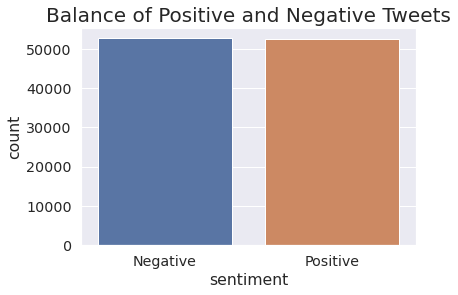

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(font_scale=1.3)
plot = sns.countplot(x = 'sentiment', data = data)
plot.set_title("Balance of Positive and Negative Tweets", fontsize=20)
plot.set_xticklabels(['Negative','Positive'])

(Reminder: 0 = negative, 1 = positive)

In [49]:
data['features']=data['tweet'].map(str)+' '+data['punctuation_count'].map(str)
data

,tweet,punctuation_count,sentiment,features
0,sleep good remedi fall asleep need one,6,0,sleep good remedi fall asleep need one 6
1,work fun,2,0,work fun 2
2,summer person love dull cold weather centralco...,3,1,summer person love dull cold weather centralco...
3,want smoke cig lighter,2,0,want smoke cig lighter 2
4,pass lot twit arriv trend topic bob,8,0,pass lot twit arriv trend topic bob 8
...,...,...,...,...
105236,i i i i i miss trip hehe turn bird amp turtl l...,15,1,i i i i i miss trip hehe turn bird amp turtl l...
105237,hump say,2,0,hump say 2
105238,seriou chemistri revis feel rather ill atm,1,0,seriou chemistri revis feel rather ill atm 1
105239,weekend go sound like time iphon poker girl let,5,0,weekend go sound like time iphon poker girl le...


In [50]:
X=data.iloc[0:,3].values.astype(str)
X

array(['sleep good remedi fall asleep need one  6', 'work fun  2',
       'summer person love dull cold weather centralcoastnsw  3', ...,
       'seriou chemistri revis feel rather ill atm  1',
       'weekend go sound like time iphon poker girl let  5',
       'uff today vote eu parliament also went made cross big piec paper  4'],
      dtype='<U146')

# Tokenize

In [51]:
tokenizer = Tokenizer(num_words=100)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_matrix(X, mode='tfidf')
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.01025613, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.92795661, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 4.40692576, 0.        ,
        4.4331292 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [52]:
maxlenth=len(max(X, key=len))
print(maxlenth)

100


In [53]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = maxlenth

X = pad_sequences(X, padding='post', maxlen=maxlen)

X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 0, 4],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [54]:
X.shape

(105241, 100)

In [55]:
y = data.sentiment
y

0         0
1         0
2         1
3         0
4         0
         ..
105236    1
105237    0
105238    0
105239    0
105240    1
Name: sentiment, Length: 105241, dtype: int64

# Split Data

In [56]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y,
                                                test_size=0.2,
                                                random_state=10, stratify=y )

In [57]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((84192, 100), (21049, 100), (84192,), (21049,))

In [58]:
# size/shape of dataframe
n_samples = Xtrain.shape[0]
n_features = Xtrain.shape[1]

# Model 1

In [59]:
# Make the NN -----------------------------------------------------------------

# Importing the Keras libraries and packages
from keras.layers import Dense
from keras.models import Sequential

# define and initialize the model
my_classifier = Sequential()

# Adding the input layer AND the first hidden layer
my_classifier.add(Dense(units = 100, kernel_regularizer='l2',
                        activation = 'sigmoid', input_dim = n_features)),
my_classifier.add(Dropout(0.2)),

# Adding the second hidden layer
my_classifier.add(Dense(units = 100, kernel_regularizer='l2',
                        activation = 'relu')),
#my_classifier.add(Dropout(0.2)),

# Adding the third hidden layer
my_classifier.add(Dense(units = 50, kernel_regularizer='l2',
                        activation = 'relu')),
#my_classifier.add(Dropout(0.2)),

# Adding the last (output) layer
my_classifier.add(Dense(units = 1, kernel_regularizer='l2',
                        activation = 'softmax'))

In [60]:
# Compiling the NN
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
my_classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy',
                      metrics = ['accuracy'])

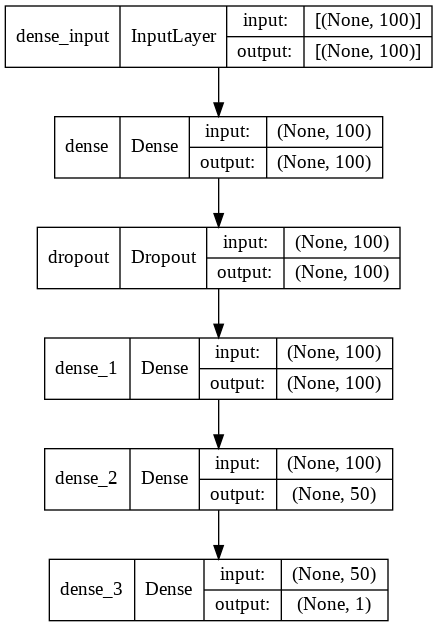

In [61]:
#-- plot the model
from keras.utils.vis_utils import plot_model
plot_model(my_classifier, to_file='model.png', show_shapes=True)

In [62]:
#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weights.hdf", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

# Fitting the ANN to the Training set
history = my_classifier.fit(Xtrain, ytrain, validation_split=0.3,
                            #batch_size = 5, 
                            epochs = 50)

Epoch 1/50
1842/1842 [==============================] - 9s 4ms/step - loss: 3.0721 - accuracy: 0.4995 - val_loss: 2.7858 - val_accuracy: 0.5000
Epoch 2/50
1842/1842 [==============================] - 7s 4ms/step - loss: 2.5430 - accuracy: 0.4995 - val_loss: 2.3145 - val_accuracy: 0.5000
Epoch 3/50
1842/1842 [==============================] - 7s 4ms/step - loss: 2.1292 - accuracy: 0.4995 - val_loss: 1.9561 - val_accuracy: 0.5000
Epoch 4/50
1842/1842 [==============================] - 7s 4ms/step - loss: 1.8176 - accuracy: 0.4995 - val_loss: 1.6874 - val_accuracy: 0.5000
Epoch 5/50
1842/1842 [==============================] - 8s 4ms/step - loss: 1.5831 - accuracy: 0.4995 - val_loss: 1.4837 - val_accuracy: 0.5000
Epoch 6/50
1842/1842 [==============================] - 7s 4ms/step - loss: 1.4039 - accuracy: 0.4995 - val_loss: 1.3279 - val_accuracy: 0.5000
Epoch 7/50
1842/1842 [==============================] - 8s 4ms/step - loss: 1.2667 - accuracy: 0.4995 - val_loss: 1.2072 - val_accuracy:

In [63]:
my_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 25,301
Trainable params: 25,301
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Make predictions
# Predicting the Test set results
y_pred_train = my_classifier.predict(Xtrain)

In [65]:
# Predicting the Test set results
y_pred_test = my_classifier.predict(Xtest)

In [66]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred_test)
cm

array([[    0, 10532],
       [    0, 10517]])

In [67]:
#confusion_mtx = tf.math.confusion_matrix(ytest, y_pred_test)
#plt.figure(figsize=(10, 8))
#sns.heatmap(confusion_mtx,
#            xticklabels=y,
#            yticklabels=y,
#            annot=True, fmt='g')
#plt.xlabel('Prediction')
#plt.ylabel('Label')
#plt.show()

In [68]:
# list all the data in history
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


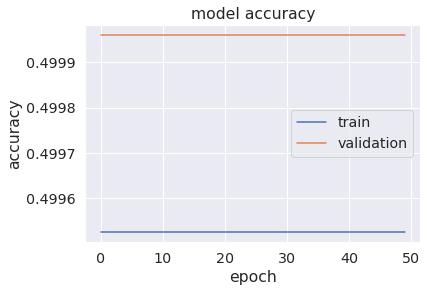

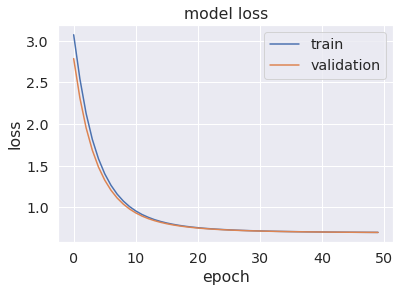

In [69]:
# Plot the accuracy for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Plot the loss for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Model 2

In [71]:
# Make the NN -----------------------------------------------------------------

# Importing the Keras libraries and packages
from keras.layers import Dense
from keras.models import Sequential

# define and initialize the model
my_classifier2 = Sequential()

# Adding the input layer AND the first hidden layer
my_classifier2.add(Dense(units = 40, kernel_initializer = 'uniform',
                        activation = 'relu', input_dim = n_features))

# Adding the second hidden layer
my_classifier2.add(Dense(units = 30, kernel_initializer = 'uniform',
                        activation = 'relu'))

# Adding the third hidden layer
my_classifier2.add(Dense(units = 15, kernel_initializer = 'uniform',
                        activation = 'relu'))


# Adding the last (output) layer
my_classifier2.add(Dense(units = 1, kernel_initializer = 'uniform',
                        activation = 'sigmoid'))

In [72]:
# Compiling the ANN
my_classifier2.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                      metrics = ['accuracy'])

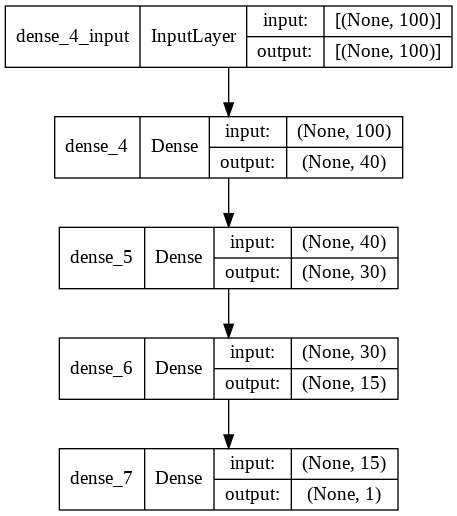

In [73]:
#-- plot the model
from keras.utils.vis_utils import plot_model
plot_model(my_classifier2, to_file='model2.png', show_shapes=True)

In [74]:
# Fitting the ANN to the Training set
history = my_classifier2.fit(Xtrain, ytrain, validation_split=0.2,
                            batch_size = 10, epochs = 60)

Epoch 1/60
6736/6736 [==============================] - 21s 3ms/step - loss: 0.6132 - accuracy: 0.6418 - val_loss: 0.6023 - val_accuracy: 0.6489
Epoch 2/60
6736/6736 [==============================] - 23s 3ms/step - loss: 0.6032 - accuracy: 0.6522 - val_loss: 0.6020 - val_accuracy: 0.6483
Epoch 3/60
6736/6736 [==============================] - 20s 3ms/step - loss: 0.5990 - accuracy: 0.6563 - val_loss: 0.5998 - val_accuracy: 0.6531
Epoch 4/60
6736/6736 [==============================] - 20s 3ms/step - loss: 0.5947 - accuracy: 0.6614 - val_loss: 0.6004 - val_accuracy: 0.6530
Epoch 5/60
6736/6736 [==============================] - 20s 3ms/step - loss: 0.5908 - accuracy: 0.6644 - val_loss: 0.6027 - val_accuracy: 0.6531
Epoch 6/60
6736/6736 [==============================] - 20s 3ms/step - loss: 0.5872 - accuracy: 0.6675 - val_loss: 0.6048 - val_accuracy: 0.6500
Epoch 7/60
6736/6736 [==============================] - 20s 3ms/step - loss: 0.5845 - accuracy: 0.6690 - val_loss: 0.6053 - val_ac

In [76]:
my_classifier2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                4040      
                                                                 
 dense_5 (Dense)             (None, 30)                1230      
                                                                 
 dense_6 (Dense)             (None, 15)                465       
                                                                 
 dense_7 (Dense)             (None, 1)                 16        
                                                                 
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Make predictions
# Predicting the Test set results
y_pred_train = my_classifier2.predict(Xtrain)

In [78]:
# Predicting the Test set results
y_pred_test = my_classifier2.predict(Xtest)

In [82]:
# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(ytest, y_pred_test)


ValueError: ignored

In [80]:
# list all the data in history
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


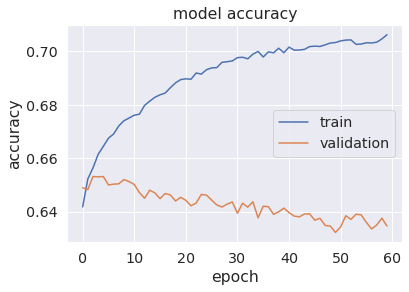

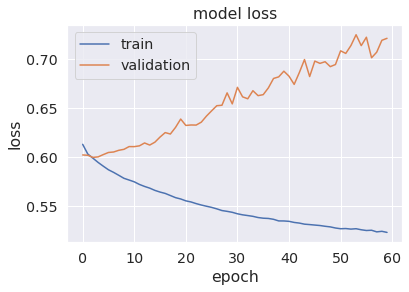

In [81]:
# Plot the accuracy for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Plot the loss for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()